## My Hello World Neural Network

In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import accuracy_score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report



## Load Data

In [2]:
website_phishing = fetch_ucirepo(id=379)

# data (as pandas dataframes)
X = website_phishing.data.features
y = website_phishing.data.targets

print(f"Dataset shape: {X.shape}")
print(f"Features: {list(X.columns)}")
print(f"Target distribution:\n{y.value_counts()}")

Dataset shape: (1353, 9)
Features: ['SFH', 'popUpWindow', 'SSLfinal_State', 'Request_URL', 'URL_of_Anchor', 'web_traffic', 'URL_Length', 'age_of_domain', 'having_IP_Address']
Target distribution:
Result
-1        702
 1        548
 0        103
Name: count, dtype: int64


## Data Visualization

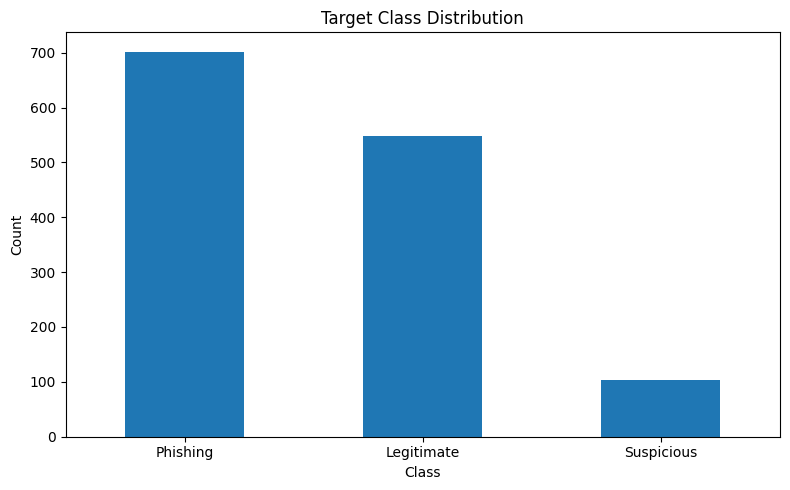

Target distribution saved!


In [3]:
df = pd.DataFrame(X.values, columns=X.columns)
df['target'] = y.values

# map target integers to meaningful labels
target_map = {-1: 'Phishing', 0: 'Suspicious', 1: 'Legitimate'}
df['target_label'] = df['target'].map(target_map)

# plot target distribution
plt.figure(figsize=(8, 5))
df['target_label'].value_counts().plot(kind='bar')
plt.title('Target Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('target_distribution.png')
plt.show()
print("Target distribution saved!")

## Split Training and Testing Data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


# Remap target values from {-1, 0, 1} to {0, 1, 2} for PyTorch
# -1 (Phishing) -> 0
#  0 (Suspicious) -> 1
#  1 (Legitimate) -> 2
target_mapping = {-1: 0, 0: 1, 1: 2}
y_train = y_train.replace(target_mapping)
y_test = y_test.replace(target_mapping)


# Convert to PyTorch Tensores (first to numpy arrays through .values)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values.flatten(), dtype=torch.long)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values.flatten(), dtype=torch.long)

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


Train set size: 1082
Test set size: 271

X_train shape: torch.Size([1082, 9])
y_train shape: torch.Size([1082])


## Define Neural Network Architecture

In [5]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size=9, hidden_size=16, output_size=3):
        super(SimpleMLP, self).__init__()

        #input layer to first hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size)

        #first hidden layer to output layer
        self.fc2 = nn.Linear(hidden_size, output_size)

        #activation function
        self.relu = nn.ReLU()


    
    def forward(self, x):
        
        # pass through first layer and apply activation
        x = self.fc1(x)
        x = self.relu(x)

        # pass through output layer
        x = self.fc2(x)
        return x



print("SimpleMLP initialized")

SimpleMLP initialized


## Helper Function for Genetic Algorithm

In [6]:
# Function to flatten model parameters into a single vector
def flatten_parameters(model: nn.Module) -> torch.Tensor:
    # This list will store flattened versions of each parameter tensor
    flat_parts = []

    # Loop over every trainable parameter in the model
    # (weights and biases, layer by layer, in a fixed order)
    for param in model.parameters():

        # Detach the parameter from PyTorch's computation graph
        # → we only want the raw numbers, not gradients
        detached = param.detach()

        # Reshape the tensor into a 1D vector
        # Example:
        # (16, 9) → (144,)
        # (30,)   → (30,)
        flattened = detached.view(-1)

        # Store the flattened tensor in the list
        flat_parts.append(flattened)

    # Concatenate all flattened parameter vectors
    # into one long 1D tensor (the genome)
    base_vector = torch.cat(flat_parts)

    # Return the complete parameter vector
    return base_vector

# Function to set model parameters from a flattened vector
def set_parameters_from_vector(model: nn.Module, vector: torch.Tensor) -> None:
    # Pointer into the genome vector
    idx = 0

    # Disable gradient tracking (we are just setting weights here)
    with torch.no_grad():

        # Loop over each parameter tensor in the model
        for param in model.parameters():

            # How many numbers does this parameter need?
            num_elements = param.numel()
            # Example:
            # fc1.weight → 16 * 9 = 144
            # fc1.bias   → 16

            # Take exactly that many values from the genome
            slice_of_vector = vector[idx : idx + num_elements]

            # Reshape the slice to match the parameter tensor
            reshaped_slice = slice_of_vector.view(param.shape)

            # Overwrite the model's parameter with new values
            param.copy_(reshaped_slice)

            # Move pointer forward
            idx += num_elements

# Evaluate fitness of a genome (parameter vector)
def evaluate_fitness(model: nn.Module, vector: torch.Tensor, X: torch.Tensor, y: torch.Tensor) -> float:

    # Disable gradient tracking for the entire function
    # (Genetic Algorithms do not use backpropagation)
    with torch.no_grad():

        # Load the genome (1D vector) into the model
        # This overwrites all weights and biases of the network
        set_parameters_from_vector(model, vector)

        # Run a forward pass on the input data
        # X shape: (num_samples, num_features)
        # outputs shape: (num_samples, num_classes)
        outputs = model(X)

        # Convert raw output scores (logits)
        # into predicted class indices
        # argmax chooses the class with the highest score
        predicted = torch.argmax(outputs, dim=1)

        # Compare predictions with true labels
        # (predicted == y) → True / False for each sample
        correct_mask = (predicted == y)

        # Convert booleans to floats (True → 1.0, False → 0.0)
        correct_float = correct_mask.float()

        # Compute mean accuracy
        accuracy = correct_float.mean()

        # Convert PyTorch scalar tensor → Python float
        fitness_value = accuracy.item()

        return fitness_value
    
# Select an individual with the best fitness from k randomly chosen candidates
def tournament_select(population, fitnesses, k=3):

    # randomly choose k distinct indices from the population
    # Example: [7, 19, 3]
    indices = np.random.choice(
        a=len(population),   # number of individuals
        size=k,              # tournament size
        replace=False        # no duplicate competitors
    )

    # collect the fitness values of those candidates
    tournament_fitnesses = []
    for i in indices:
        tournament_fitnesses.append(fitnesses[i])

    # find which candidate has the highest fitness
    # argmax returns the POSITION inside tournament_fitnesses
    best_position = np.argmax(tournament_fitnesses)

    # map that position back to the original population index
    best_idx = indices[best_position]

    # return the winning individual (genome)
    return population[best_idx]

# Perform uniform crossover between two parent genomes
def uniform_crossover(parent1, parent2, prob=0.5):

    # create a random mask of the same shape as the parents
    # Each entry is a random number in [0, 1)
    random_values = torch.rand_like(parent1)

    # turn random numbers into a boolean decision mask
    # True  → take gene from parent1
    # False → take gene from parent2
    mask = random_values < prob

    # create the child genome gene-by-gene
    child = torch.empty_like(parent1)

    for i in range(len(parent1)):
        if mask[i]:
            child[i] = parent1[i]
        else:
            child[i] = parent2[i]

    return child

# Mutate a genome by adding uniform noise to some genes
def mutate( vector: torch.Tensor, mutation_rate: float = 0.05, step: float = 0.1) -> torch.Tensor:


    # Create a copy so we do NOT change the original vector
    mutated_vector = vector.clone()

    # Loop over every gene (weight / bias)
    for i in range(len(mutated_vector)):

        # Draw a random number between 0 and 1
        random_value = torch.rand(1).item()

        # Decide whether this gene mutates
        if random_value < mutation_rate:

            # Draw a random value uniformly from [-step, +step]
            noise = (torch.rand(1).item() * 2 - 1) * step

            # Add the noise to this gene
            mutated_vector[i] = mutated_vector[i] + noise

        # else:
        #   do nothing → gene stays exactly the same

    # Return the mutated genome
    return mutated_vector



## Main GA Loop

In [7]:
# --- Hyperparameters ---
population_size = 40
generations = 60
elitism = 2
tournament_k = 3
crossover_prob = 0.5
mutation_rate = 0.05
mutation_step = 0.1

# --- Make a fresh model blueprint ---
_ga_model = SimpleMLP(input_size=9, hidden_size=16, output_size=3)

# --- Create initial population (genomes) from model's initialized params ---
base_vector = flatten_parameters(_ga_model)
genome_length = base_vector.numel()

population = []
for _ in range(population_size):
    # start near the base initialization, with small random noise
    individual = base_vector.clone()
    individual = mutate(individual, mutation_rate=1.0, step=0.02)  # tiny jitter for diversity
    population.append(individual)

# --- Track best solution across all generations ---
best_fitness_so_far = float("-inf")
best_vector = None
fitness_history = []

# --- Evolution loop ---
for gen in range(generations):

    # Evaluate fitness for entire population (once per generation)
    fitnesses = []
    for individual in population:
        fit = evaluate_fitness(_ga_model, individual, X_train, y_train)
        fitnesses.append(fit)

    # Find best in THIS generation
    gen_best_idx = int(np.argmax(fitnesses))
    gen_best_fitness = fitnesses[gen_best_idx]

    # Update best-so-far
    if gen_best_fitness > best_fitness_so_far:
        best_fitness_so_far = gen_best_fitness
        best_vector = population[gen_best_idx].clone()  #  so it can't be altered later

    # Logging + history
    fitness_history.append(best_fitness_so_far)
    if (gen + 1) % 10 == 0 or gen == 0:
        print(f"Generation {gen+1}/{generations} | Best so far: {best_fitness_so_far:.4f} | Gen best: {gen_best_fitness:.4f}")

    # Elitism (carry over top performers unchanged)
    sorted_indices = np.argsort(fitnesses)[::-1]  # descending
    new_population = []
    for i in range(elitism):
        elite_idx = sorted_indices[i]
        new_population.append(population[elite_idx].clone())

    # Fill rest of population with selection + crossover + mutation
    while len(new_population) < population_size:

        # Select parents
        parent1 = tournament_select(population, fitnesses, k=tournament_k)
        parent2 = tournament_select(population, fitnesses, k=tournament_k)

        # Crossover
        child = uniform_crossover(parent1, parent2, prob=crossover_prob)

        # Mutation
        child = mutate(child, mutation_rate=mutation_rate, step=mutation_step)

        new_population.append(child)

    # Replace population
    population = new_population

# --- After training: best_vector contains the best genome found ---
print("\nTraining finished.")
print(f"Best training fitness achieved: {best_fitness_so_far:.4f}")




Generation 1/60 | Best so far: 0.5028 | Gen best: 0.5028
Generation 10/60 | Best so far: 0.6331 | Gen best: 0.6331
Generation 20/60 | Best so far: 0.7856 | Gen best: 0.7856
Generation 30/60 | Best so far: 0.8346 | Gen best: 0.8346
Generation 40/60 | Best so far: 0.8447 | Gen best: 0.8447
Generation 50/60 | Best so far: 0.8549 | Gen best: 0.8549
Generation 60/60 | Best so far: 0.8567 | Gen best: 0.8567

Training finished.
Best training fitness achieved: 0.8567


## Evaluate Genetic Algorithm

c:\Users\flori\OneDrive\Desktop\imc\semester_three\algorithms\assignment\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\flori\OneDrive\Desktop\imc\semester_three\algorithms\assignment\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\flori\OneDrive\Desktop\imc\semester_three\algorithms\assignment\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

Test set results:
Accuracy: 0.8044
Precision (weighted): 0.7337
Recall (weighted): 0.8044
F1-score (weighted): 0.7661

Classification report:
              precision    recall  f1-score   support

           0     0.8507    0.8636    0.8571       132
           1     0.0000    0.0000    0.0000        25
           2     0.7591    0.9123    0.8287       114

    accuracy                         0.8044       271
   macro avg     0.5366    0.5920    0.5619       271
weighted avg     0.7337    0.8044    0.7661       271



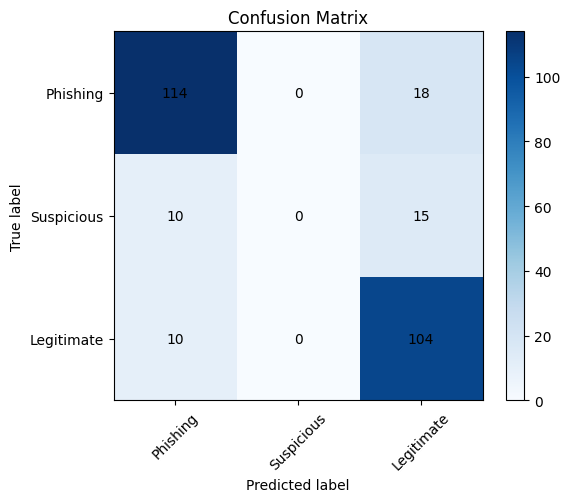

Confusion matrix saved to confusion_matrix.png


In [8]:
# --- Evaluate best_vector on the TEST set (accuracy, precision, recall, F1, confusion matrix) ---

if best_vector is None:
    print('No best_vector found. Run the GA loop first to produce best_vector.')
else:
    # load best parameters into the model
    set_parameters_from_vector(_ga_model, best_vector)

    with torch.no_grad():
        outputs = _ga_model(X_test)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_true = y_test.cpu().numpy()

    acc = accuracy_score(y_true, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, preds, average='weighted')
    cm = confusion_matrix(y_true, preds)

    print('Test set results:')
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision (weighted): {precision:.4f}')
    print(f'Recall (weighted): {recall:.4f}')
    print(f'F1-score (weighted): {f1:.4f}')
    print('\nClassification report:')
    print(classification_report(y_true, preds, digits=4))

    # Plot and save confusion matrix
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    labels = ['Phishing','Suspicious','Legitimate']
    # if number of classes differs, fall back to numeric labels
    if cm.shape[0] != len(labels):
        labels = [str(i) for i in range(cm.shape[0])]
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]), ha='center', va='center', color='black')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    print('Confusion matrix saved to confusion_matrix.png')

## Plot Generations 

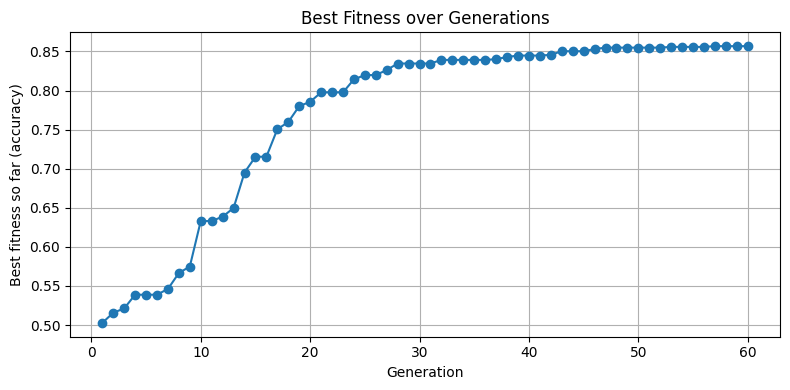

Fitness history plot saved to fitness_history.png


In [9]:
if 'fitness_history' not in globals() or len(fitness_history) == 0:
    print('No fitness_history available. Run the GA loop to populate fitness_history.')
else:
    plt.figure(figsize=(8,4))
    plt.plot(range(1, len(fitness_history)+1), fitness_history, marker='o')
    plt.title('Best Fitness over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best fitness so far (accuracy)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('fitness_history.png')
    plt.show()
    print('Fitness history plot saved to fitness_history.png')

## Backpropagation — comparison

In [10]:
# Create a fresh model instance so GA model remains unchanged
bp_model = SimpleMLP(input_size=9, hidden_size=16, output_size=3)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bp_model.parameters(), lr=0.01)

# Prepare training data references (already converted to tensors earlier)
X_train_bp = X_train.clone()  
y_train_bp = y_train.clone()  

# Training hyperparameters
epochs = 60
batch_size = 32
num_samples = X_train_bp.shape[0]

# Containers to store per-epoch info
train_losses = []
test_accs = []  

# Training loop 
for epoch in range(1, epochs + 1):
    bp_model.train()  # set model to training mode
    # Shuffle indices for this epoch
    indices = torch.randperm(num_samples)
    running_loss = 0.0

    # Process mini-batches explicitly
    for start in range(0, num_samples, batch_size):
        end = start + batch_size
        batch_idx = indices[start:end]
        xb = X_train_bp[batch_idx]  # input batch
        yb = y_train_bp[batch_idx]  # label batch
        # Zero gradients from previous step
        optimizer.zero_grad()
        # Forward pass: compute logits
        logits = bp_model(xb)
        # Compute loss (CrossEntropy expects raw logits)
        loss = criterion(logits, yb)
        # Backward pass: compute gradients
        loss.backward()
        # Update model parameters
        optimizer.step()
        # Accumulate loss for reporting (sum over samples)
        running_loss += loss.item() * xb.size(0)

    
    # End of epoch: compute average loss
    avg_loss = running_loss / num_samples
    train_losses.append(avg_loss)
    # quick test-set check 
    bp_model.eval()

    with torch.no_grad():
        test_logits = bp_model(X_test)
        test_preds = torch.argmax(test_logits, dim=1).cpu().numpy()
        test_labels = y_test.cpu().numpy()
        test_acc = accuracy_score(test_labels, test_preds)
        test_accs.append(test_acc)

    
    # Print progress every 10 epochs and first epoch
    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs} — avg loss: {avg_loss:.4f} — test acc: {test_acc:.4f}')



# Save the trained model object for later evaluation cell
trained_bp_model = bp_model
print('Training complete — model saved to variable `trained_bp_model`.')

Epoch 1/60 — avg loss: 0.6539 — test acc: 0.7970
Epoch 10/60 — avg loss: 0.3090 — test acc: 0.8524
Epoch 20/60 — avg loss: 0.2641 — test acc: 0.8524
Epoch 30/60 — avg loss: 0.2310 — test acc: 0.8782
Epoch 40/60 — avg loss: 0.2080 — test acc: 0.8819
Epoch 50/60 — avg loss: 0.1933 — test acc: 0.8930
Epoch 60/60 — avg loss: 0.1806 — test acc: 0.8893
Training complete — model saved to variable `trained_bp_model`.


## Backpropargation Evaluation

In [14]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate_model(model, X_test, y_test, class_names=None):
    model.eval()
    with torch.no_grad():
        logits = model(X_test)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        ytrue = y_test.cpu().numpy()

    acc = accuracy_score(ytrue, preds)
    cm = confusion_matrix(ytrue, preds)

    print(f"Test Accuracy: {acc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
    print("\nClassification Report:")
    print(classification_report(ytrue, preds, target_names=class_names, digits=4))

    return acc, cm

class_names = ["Phishing", "Suspicious", "Legitimate"]  
acc, cm = evaluate_model(trained_bp_model, X_test, y_test, class_names)


Test Accuracy: 0.8893

Confusion Matrix:
[[121   3   8]
 [  1  17   7]
 [ 10   1 103]]

Classification Report:
              precision    recall  f1-score   support

    Phishing     0.9167    0.9167    0.9167       132
  Suspicious     0.8095    0.6800    0.7391        25
  Legitimate     0.8729    0.9035    0.8879       114

    accuracy                         0.8893       271
   macro avg     0.8664    0.8334    0.8479       271
weighted avg     0.8884    0.8893    0.8882       271



In [15]:

# Evaluate GA model (uses `best_vector` and `_ga_model`)
acc_ga = None
try:
    set_parameters_from_vector(_ga_model, best_vector)
    _ga_model.eval()
    with torch.no_grad():
        out_ga = _ga_model(X_test)
        preds_ga = torch.argmax(out_ga, dim=1).cpu().numpy()
        y_true = y_test.cpu().numpy()
    acc_ga = accuracy_score(y_true, preds_ga)
except Exception:
    # if GA not run yet, leave acc_ga as None
    acc_ga = None

# Evaluate backprop model (uses `trained_bp_model`)
trained_bp_model.eval()
with torch.no_grad():
    out_bp = trained_bp_model(X_test)
    preds_bp = torch.argmax(out_bp, dim=1).cpu().numpy()
y_true = y_test.cpu().numpy()
acc_bp = accuracy_score(y_true, preds_bp)

print('Simple comparison:')
print(f'GA accuracy        : {acc_ga:.4f}' if acc_ga is not None else 'GA accuracy        : N/A')
print(f'Backprop accuracy  : {acc_bp:.4f}')


Simple comparison:
GA accuracy        : 0.8044
Backprop accuracy  : 0.8893
